# Analysis of HD10700 Spectra

## Cleaning and Plotting data

In this step, we will plot all available data for the Star and also look at the Lomb Scargle Periodogram to identfy possible RV signals due to planets, companions stars or mag activity. Before this is done the blaze function is fitted to the original blaze uncorrected spectra. Please check if the provided targetname and spectra directory are correct.

In [1]:
star_name = 'HD10700'
directory_name = '/home/aaron/Desktop/ZASPE/Spectra/HD10700'

## Calculate wavelength calibration from Polynomials

In [2]:
     
from funcs import collect_fits_files, separate_fits_files
    
fits_files = collect_fits_files(directory_name,extension="A.fits")
fits_files, ccf_files = separate_fits_files(fits_files)
    
from funcs import calculate_wavelengths 

wavelengths = calculate_wavelengths(fits_files, directory_name)
observed_wavelengths = wavelengths     
    

Shape of wavelengths array: (77, 72, 4096)


### Apply the blaze correction by fitting a Polynomial to Blaze Uncorrected Spectra

In [3]:
   
from funcs import apply_blaze_correction

discarded_nights = apply_blaze_correction(observed_wavelengths,fits_files,ccf_files,directory_name)

  0%|          | 0/77 [00:00<?, ?it/s]

In [8]:
discarded_nights =[]

In [3]:

#remove nights to be discarded
import numpy as np
#wavelenghts = np.delete(wavelengths,discarded_nights,axis = 0)

#fits_files = [fits_file for i, fits_file in enumerate(fits_files) if i not in discarded_nights]
#ccf_files = [ccf_file for i, ccf_file in enumerate(ccf_files) if i not in discarded_nights]    
    
    
#collect all fits files in the given directory
fits_files = collect_fits_files(directory_name, extension = 'blaze_correction.fits')
    

### Plot the blaze corrected spectra

The the step takes long due to extensive plotting. The .png files are stored in Plots/star_name_observer_night.png. The star name is obtained from simbad. Default is Gliese catalog, if not available it will use Henry Draper and otherwise Tess Input. \ You do not have to run the next 2 cells as it takes long. However, if you are interested in how the spectra look, you might want to take a peak.

In [ ]:

from funcs import plot_arrays, query_tic_name,query_gliese_name,query_HD_name, extract_target_info, extract_target_info_astropy
import matplotlib.pyplot as plt
from astropy.io import fits 
from tqdm.notebook import tqdm
from time import sleep
import re

for i in tqdm(range(len(fits_files))): 
    spectrum = fits.getdata(fits_files[i])
    flux = spectrum[3,:] #CERES pipeline blaze corrected flux
    wavelength = spectrum[0,:]
    string = fits_files[i] 
    cut_string = string.split("/")[-1][:38] + ".png"
    
    target_name, observed_night = extract_target_info_astropy(fits_files[i])
    t1 = target_name 
    if target_name.startswith("GJ") == False:
        target_name = query_gliese_name(target_name)    #try to get gliese id
    if target_name == "Unknown":
        target_name = query_HD_name(t1)   #try to get HD id
    if target_name == "Unknown":
        target_name = query_tic_name(t1) # try to get TIC id
      
      
    #make sure there is no whitespaces in the target_name
    pattern = re.compile(r'\s+')
    target_name = re.sub(pattern, '', target_name)
    
    file_name = target_name + observed_night + ".png"
    save_dir = "Plots/" + target_name
    
    plot_arrays(flux,wavelength,save_dir=save_dir, save_filename=file_name)
    
    sleep(3)

  0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:

#example plot
#add the file you intend to show
example_file = save_dir + "/" + file_name
from IPython.display import display, Image
display(Image(filename=example_file))

### RV Analyis

In [4]:

from funcs import get_RV_BJD
#obtain RV, RV uncertainty and BJD from the CCFs 
rv, rv_err, bjd = get_RV_BJD(ccf_files)

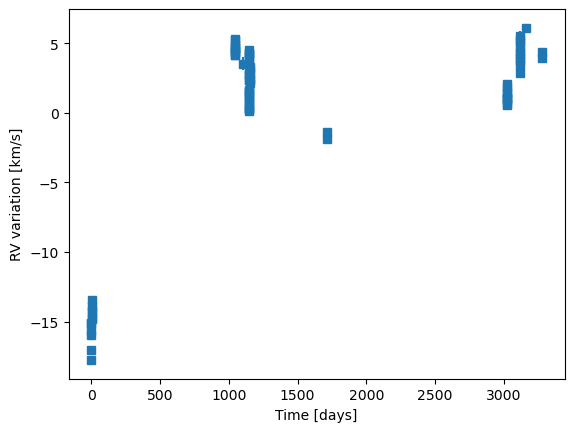

In [5]:

#plotting the RV variation
from funcs import plot_rvs

save_dir = 'Plots/' + star_name 
file_name = star_name + "_RV_variation.png"
plot_rvs(rv,rv_err/1000, bjd,save_dir, file_name) 

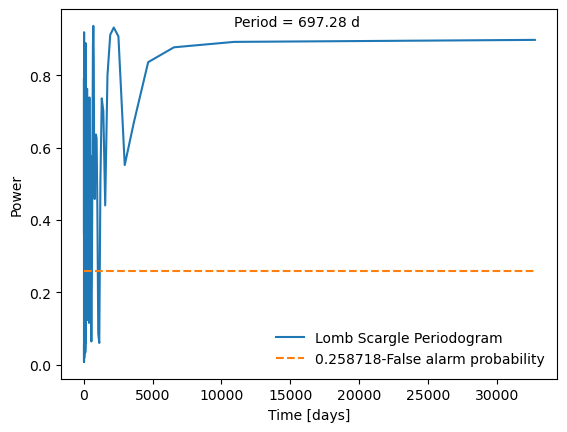

In [29]:

#plotting the LS Periodogram
from funcs import plot_lomb_scargle

file_name = star_name + "_Lomb_Scargle.png"
plot_lomb_scargle(bjd, rv, rv_err/1000, 0.01, save_dir= save_dir, save_filename=file_name)

Comments: Clear Evidence of different periods where there might be an RV signal. It is a planet system: https://en.wikipedia.org/wiki/Tau_Ceti 

Lets refine the LS periodogram to get a better few on it. 

In [7]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(bjd-np.min(bjd),rv-np.mean(rv),rv_err/1000 ).autopower()

In [12]:
# Periods of the planets 

b = 13.85 #unconfirmed
c = 35.364 #unconfirmed
d = 94.11 #unconfirmed
e = 162.87 #conf
f = 636.12 #conf
g = 20.00 #conf
h = 49.41 #conf 

(15.0, 100.0)

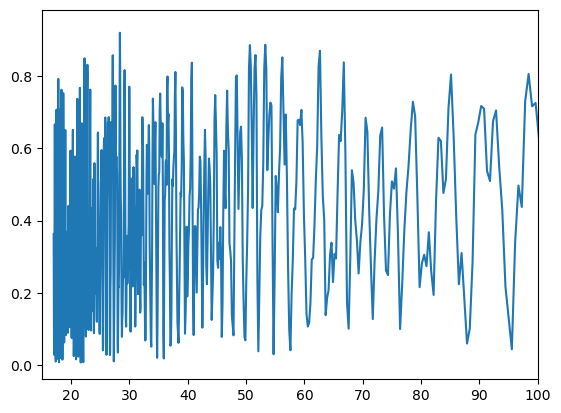

In [19]:
import matplotlib.pyplot as plt
plt.plot(1/frequency, power)
plt.xlim(15,100)

Comment: Possible peaks below 20 (b?), three peaks between 20-30 (g), two between 30-40 (c), two between 50-60 (h), one around 60

(100.0, 800.0)

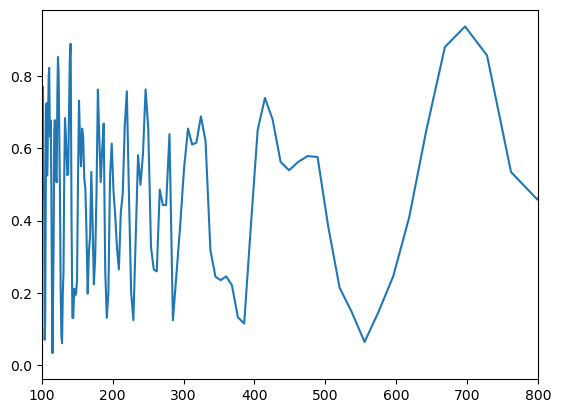

In [22]:
import matplotlib.pyplot as plt
plt.plot(1/frequency, power)
plt.xlim(100,800)

Comments: Before 700 (f), between 100-200 ca.150 (e at 162)

## Combine and Align Spectra

In this step, we will combine and align all available spectra in the same time frame while removing artifacts that we dont want to have in the combined spectra, like saturation or cosmic rays. We will use two methods to combine the spectra - RV - correction method and Cross-Correlation Method.

### RV correction method

The RV correction is performed using the measured RVs by Harps. The wavelengths are then corrected for RV shift due to different time frames and moved to the first obervation night.

Night 22 in Order 3 has been discarded due to non-contributing flux.
Night 22 in Order 5 has been discarded due to non-contributing flux.
Night 22 in Order 6 has been discarded due to non-contributing flux.
Night 22 in Order 7 has been discarded due to non-contributing flux.
Night 22 in Order 8 has been discarded due to non-contributing flux.
Night 22 in Order 9 has been discarded due to non-contributing flux.
Night 22 in Order 10 has been discarded due to non-contributing flux.
Night 22 in Order 11 has been discarded due to non-contributing flux.
Night 22 in Order 12 has been discarded due to non-contributing flux.
Night 22 in Order 13 has been discarded due to non-contributing flux.
Night 22 in Order 14 has been discarded due to non-contributing flux.
Night 22 in Order 15 has been discarded due to non-contributing flux.
Night 22 in Order 17 has been discarded due to non-contributing flux.
Night 22 in Order 18 has been discarded due to non-contributing flux.
Night 22 in Order 20 has b

<IPython.core.display.Javascript object>


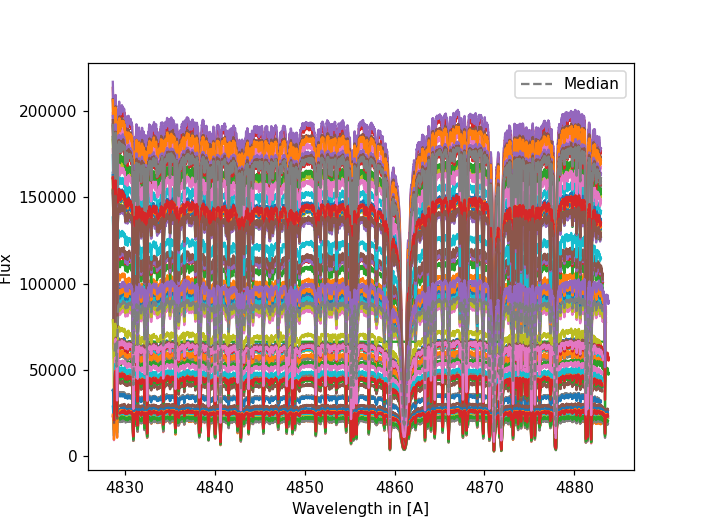

In [14]:
  
import scipy.constants as c

c_km = c.c/1000 
    
    
%matplotlib notebook
from funcs import plot_fluxes, plot_median_spectrum, interpolate_flux, get_wavelength_flux_RV, save_spectrum_as_text 

#get fit files
filelist = fits_files

#get observed wavelength, flux and eflux; extract RV and calculate corrected wavelength
wave, flux, eflux, RV, BERV, wave_corr, combined_orders = get_wavelength_flux_RV(filelist, ceres = False)

#get reference wavelength from first observation night 
wave_ref_corr = wave[0] / (1 + RV[0] / c_km) 

#interpolate flux at corrected wavelength and on the corrected wavelegnths reference
flux_interp = interpolate_flux(wave, flux, wave_ref_corr, RV, BERV)

#median flux for specific order
flux_median = np.median(flux_interp, axis=0)

#controll plots for specific order
norder = 35 
plot_fluxes(wave_corr, flux, norder) 
plot_median_spectrum(wave_ref_corr, flux_median+3000, norder)   

#save the spectrum as txt file for ZASPE
save_directory = "Spectra/" + star_name + "/" + star_name + "_RV_method.txt" 
save_spectrum_as_text(combined_orders, wave_ref_corr, flux_median, save_directory)
    

### Cross-correlation method

The cross-correlation method takes the median flux from the RV method as star templat to correlate with. It then performes combines and alignes the spectra via cross correlation to the reference template. At the moment there are some issus with the cc method why using only RV method is recommended. In principle should the RV method result in the most accurate shift to the assigned reference spectrum.

In [15]:
    
from funcs import align_spectra
from funcs import combine_spectra
from astropy.io import fits 
import matplotlib.pyplot as plt

num_orders = np.shape(fits.getdata(fits_files[0]))[1]

#template is the RV corrected version
template = flux_median 

#Specify the spectral order to combine
combined_spectra = []
for i in range(num_orders):
    combined_spectrum = combine_spectra(fits_files, i, template, blaze_corrected=True)
    combined_spectra.append(np.array(combined_spectrum))

combined_spectra = np.array(combined_spectra)

#get wavelength for plotting
spectrum = fits.getdata(fits_files[0])
flux = spectrum[1,:]
wavelength = spectrum[0,:]
blaze_corrected_flux = spectrum[3,:]

Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 0 has been discarded due to significant deviation. Median value 457.2355445874096
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 1 has been discarded due to significant deviation. Median value 503.2888956982489
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 2 has been discarded due to significant deviation. Median value 819.7822472866727
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 3 has been discarded due to significant deviation. Median value 853.4547375993939
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 5 has been discarded due to significant deviation. Median valu

Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 41 has been discarded due to significant deviation. Median value 16983.085166908015
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 42 has been discarded due to significant deviation. Median value 17600.31975586474
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 43 has been discarded due to significant deviation. Median value 17055.861791586874
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 44 has been discarded due to significant deviation. Median value 18795.102047818873
Spectrum from night /home/aaron/Desktop/ZASPE/Spectra/HD10700/HARPS2015-11-23T06:09:36.880_blaze_correction.fits in order 45 has been discarded due to significant deviation. Med

<IPython.core.display.Javascript object>


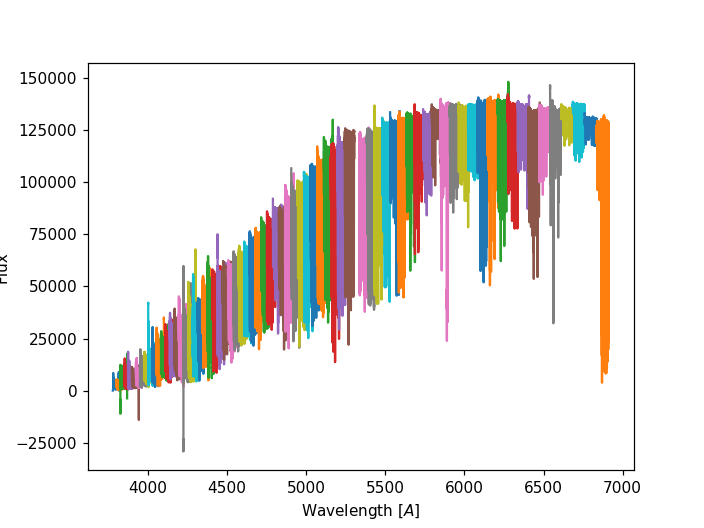

In [16]:

%matplotlib notebook 

import matplotlib.pyplot as plt 
plt.xlabel(r"Wavelength $[A]$")
plt.ylabel(r"Flux")
for i in range(len(wavelength)):
    plt.plot(wavelength[i], combined_spectra[:,2][i])


In [17]:
from funcs import store_spectrum_orders
save_dir = "Spectra/" + star_name + "/"

#Cross correlation method    
file_name = star_name + "_CCM" + ".txt"

store_spectrum_orders(combined_spectra[:,1],combined_spectra[:,2], save_dir = save_dir, file_name = file_name )

The spectrum for all orders has been stored in the file: Spectra/HD10700/HD10700_CCM.txt
